# **Save this file as studentid1_studentid2_lab2.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 2 people, the notebook should be named:
12301230_3434343_lab2.ipynb.

**IMPORTANT: This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".**

**Finally, add your names and email adresses below.**



NAME = "Boaz Beukers" 

NAME2 = "Didier Merk" 

EMAIL = "boazbeuk007@gmail.com" 

EMAIL2 = "didier.merk@gmail.com" 

## Lab assignment 2: Gaussian Processes and Support Vector Machines

### Machine Learning 1, October 2022

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* use the provided test boxes to check if your answers are correct
* **Do not change the arugments in our functions!**
* **Do not remove add new cells. If you do you should expect a penalty in your assignment!**

In [27]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\didie\anaconda3\envs\ml1labs\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['mean', 'indices', 'std', 'beta']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [28]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

## Part 1: Gaussian Processes

For part 1 we will be refer to Bishop sections 6.4.2 and 6.4.3. You may also want to refer to Rasmussen's Gaussian Process text which is available online at http://www.gaussianprocess.org/gpml/chapters/ and especially to the project found at https://www.automaticstatistician.com/index/ by Ghahramani for some intuition in GP.  To understand Gaussian processes, it is highly recommended understand how marginal, partitioned Gaussian distributions can be converted into conditional Gaussian distributions.  This is covered in Bishop 2.3 and summarized in Eqns 2.94-2.98.
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\ba}{\mathbf{a}}$

### Periodic Data

We will use the same data generating function that we used previously for regression.

In [29]:
def true_mean_function(x):
    return np.sin(2*pi*(x+1))

def add_noise(y, sigma):
    return y + sigma*np.random.randn(len(y))

def generate_t(x, sigma):
    return add_noise(true_mean_function(x), sigma)


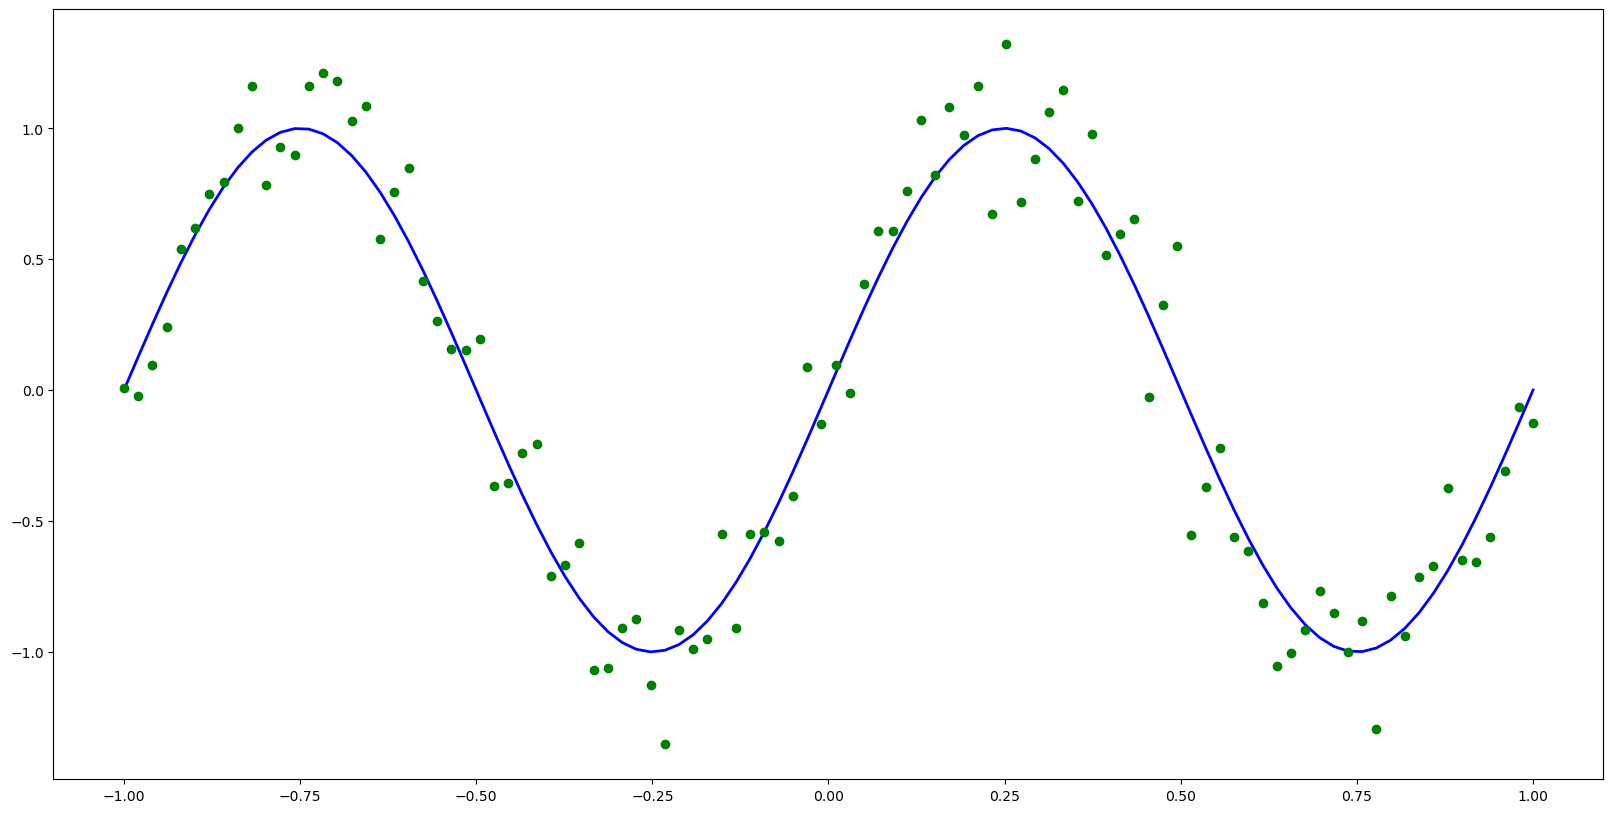

In [30]:
sigma = 0.2
beta  = 1.0 / pow(sigma, 2)
N_test = 100

x_test = np.linspace(-1, 1, N_test) 
mu_test = np.zeros(N_test)
y_test = true_mean_function(x_test)
t_test = add_noise(y_test, sigma)

plt.plot( x_test, y_test, 'b-', lw=2)
plt.plot( x_test, t_test, 'go')
plt.show()

### 1. Sampling from the Gaussian process prior (30 points)
We will implement Gaussian process regression using the kernel function in Bishop Eqn. 6.63.  

#### 1.1 Why kernel function? (5 points)

Before implementing kernel function, it would be useful to understand why kernels are crucial for high dimensional data. Why are kernels useful when you are dealing with high dimensional data?

**Answer**: In the "real" world, almost all data is not linearly seperable. Kernels are crucial for high dimensional data, that is because they are able to map non-linear data into a higher dimension in which they become linearly seperable. The kernel trick allows us to transform data into a higher dimension in a more efficient and less expensive way; as well as allowing us to finding the most optimal way to seperate this higher dimensional data without having to "know" anything about all the features.

#### 1.2 k_n_m( xn, xm, thetas ) (5 points)
To start, implement function `k_n_m(xn, xm, thetas)` that takes scalars $x_n$ and $x_m$, and a vector of $4$ thetas, and computes the kernel function Bishop Eqn. 6.63 (10 points).  NB: usually the kernel function will take $D$ by $1$ vectors, but since we are using a univariate problem, this makes things easier.

In [37]:
def k_n_m(xn, xm, thetas):
    
    # Implement formula from Bishop (6.63)
    k = thetas[0] * np.exp(-(thetas[1] / 2) * (np.linalg.norm(xn - xm))**2) + thetas[2] + thetas[3] * np.dot(xn, xm)
    
    return k

In [38]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests


#### 1.3 computeK( X1, X2, thetas ) (10 points)
Eqn 6.60 is the marginal distribution of mean output of $N$ data vectors: $p(\mathbf{y}) = \mathcal{N}(0, \mathbf{K})$.  Notice that the expected mean function is $0$ at all locations, and that the covariance is a $N_{x_1}$ by $N_{x_2}$ kernel matrix $\mathbf{K}$.  Write a function `computeK(x1, x2, thetas)`
that computes the kernel matrix. Use k_n_m as part of an inner loop (of course, there are more efficient ways of computing the kernel function making better use of vectorization, but that is not necessary).  

In [39]:
def computeK(x1, x2, thetas):
    
    # Initialize zero-matrix with correct size
    rows = len(x1)
    cols = len(x2)
    
    K = np.zeros((rows, cols))
    
    # Start filling the matrix
    for i in range(rows):
        for j in range(cols):
            K[i][j] = k_n_m(x1[i], x2[j], thetas)
            
    return K

In [40]:
### Test your function
x1 = [0, 1, 2]
x2 = [1, 2, 3, 4]
thetas = [1, 2, 3, 4]
K = computeK(x1, x2, thetas)


assert K.shape == (len(x1), len(x2)), "the shape of K is incorrect"


#### 1.4 Plot function samples (15 points)
Now sample mean functions at the x_test locations for the theta values in Bishop Figure 6.5, make a figure with a 2 by 3 subplot and make sure the title reflects the theta values (make sure everything is legible).  In other words, sample $\by_i \sim \mathcal{N}(0, \mathbf{K}_{\theta})$.  Make use of numpy.random.multivariate_normal().  On your plots include the expected value of $\by$ with a dashed line and fill_between 2 standard deviations of the uncertainty due to $\mathbf{K}$ (the diagonal of $\mathbf{K}$ is the variance of the model uncertainty) (15 points).

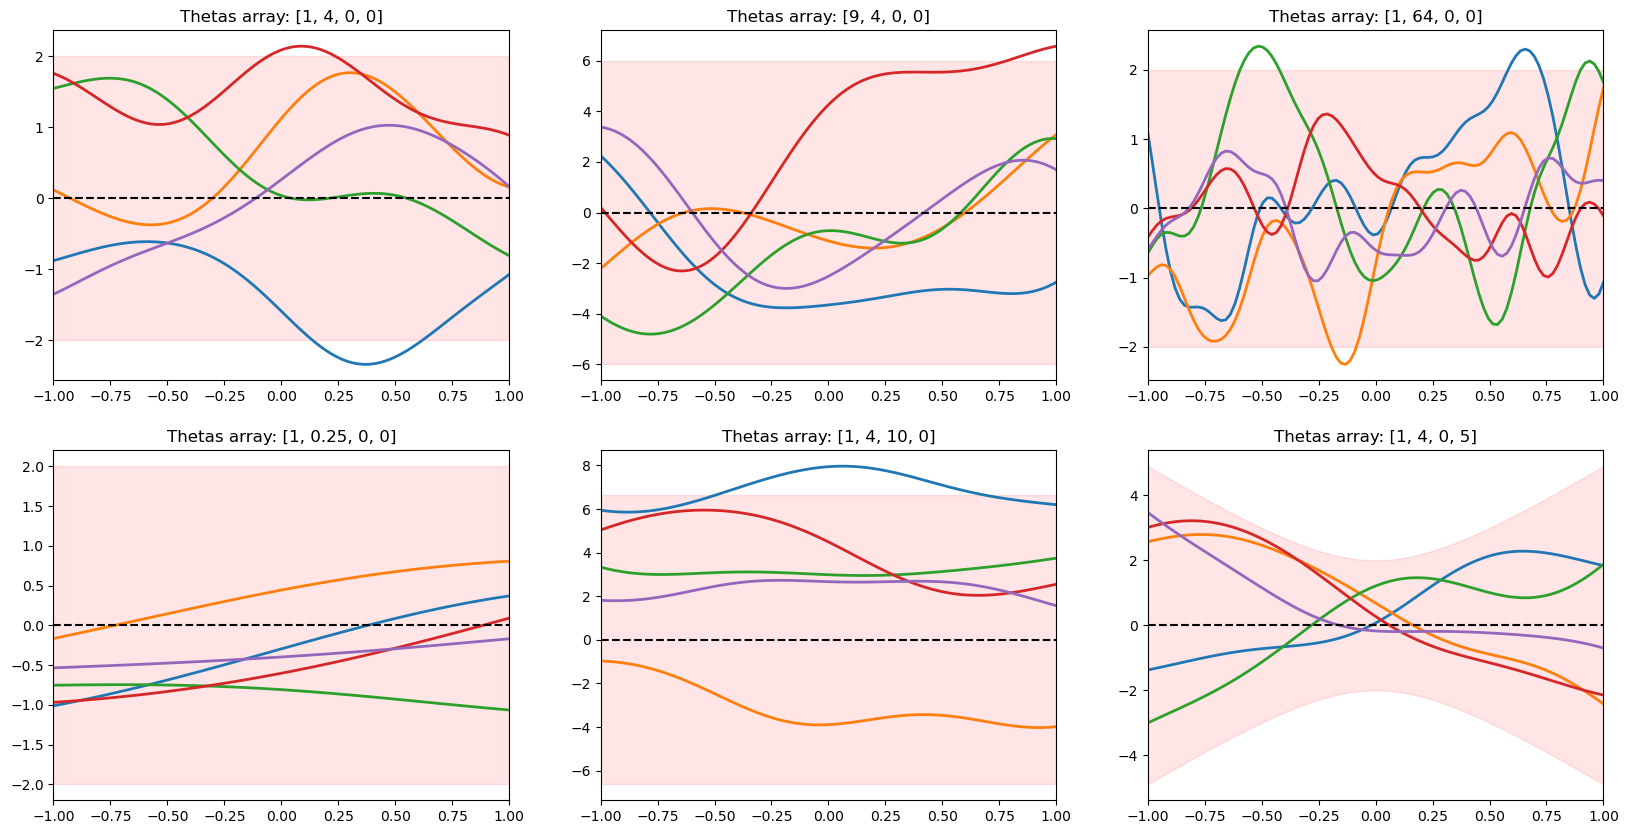

In [43]:
# Retrieve the theta values from Bishop Figure 6.5:
thetas = [[[1, 4, 0, 0], [9, 4, 0, 0], [1, 64, 0, 0]],
          [[1, 0.25, 0, 0], [1, 4, 10, 0], [1, 4, 0, 5]]]

# We know the mean of the Gaussian to be 0, but with the length of x_test
mean = mu_test

# Initialize the figure for the plotting
fig, axs = plt.subplots(2, 3)

# How many sample mean functions we want
num_samples = 5

# Loop over all the thetas and plots using a double for-loop
for row in range(2):
    for column in range(3):
        
        # Take the current theta
        theta = thetas[row][column]
        
        # Retrieve the K-matrix using x_test and the theta
        K = computeK(x_test, x_test, theta)

        # The diagonal of matrix K is the variance of the model uncertainty
        std = np.sqrt(np.diag(K))
        
        # The expected value of y is 0 because it is drawn from the multivariate normal with a mean of 0
        exp_y = [0] * (len(x_test))
        
        # Plot your samples
        for i in range(num_samples):
            
            # Draw points from the Gaussian
            y_i = np.random.multivariate_normal(mu_test, K)

            # Plotting sampled y, expected y and standard deviation
            axs[row][column].plot(x_test, y_i, '-', linewidth=2)
        
        # Plot the expected value of y
        axs[row][column].plot(x_test, exp_y, '--', color='black', label='Expected y')
        
        # Plot the standard deviation twice above and below exp_y
        axs[row][column].fill_between(x_test, exp_y + 2*std, exp_y - 2*std, alpha=0.1, 
                                      color='red', label='Standard Deviation')
        
        # Plotting layout settings
        axs[row][column].set_xlim([-1, 1])
        axs[row][column].set_title(f'Thetas array: {theta}')

plt.show()

### 2. Predictive distribution (35 points)
So far we have sampled mean functions from the prior.  We can draw actual data $\bt$ two ways.  The first way is generatively, by first sampling $\by | \mathbf{K}$, then sampling $\bt | \by, \beta$ (Eqns 6.60 followed by 6.59).  The second way is to integrate over $\by$ (the mean draw) and directly sample $\bt | \mathbf{K}, \beta$ using Eqn 6.61.    This is the generative process for $\bt$.  Note that we have not specified a distribution over inputs $\bx$;  this is because Gaussian processes are conditional models.  Because of this we are free to generate locations $\bx$ when playing around with the GP; obviously a dataset will give us input-output pairs.

Once we have data, we are interested in the predictive distribution (note: the prior is the predictive distribution when there is no data).  Consider the joint distribution for $N+1$ targets, given by Eqn 6.64.  Its covariance matrix is composed of block components $\mathbf{C}_N$, $\mathbf{k}$, and $c$.  The covariance matrix $\mathbf{C}_N$ for $\bt_N$ is $\mathbf{C}_N = \mathbf{K}_N + \beta^{-1}\mathbf{I}_N$.  We have just made explicit the size $N$ of the matrix; $N$ is the number of training points.  The kernel vector $\mathbf{k}$ is a $N$ by $1$ vector of kernel function evaluations between the training input data and the test input vector.  The scalar $c$ is a kernel evaluation at the test input.

#### 2.1 gp_predictive_distribution(...) (10 points)
Write a function `gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C=None)` that computes  Eqns 6.66 and 6.67, except allow for an arbitrary number of test points (not just one) and now the kernel matrix is for training data. We have:

- $\mathbf{K}$: $K_{n,m} = k(x_{\text{train},n}, x_{\text{train},m})$; $\mathbf{K}$ is a $N_\text{train}\times N_\text{train}$ matrix
- $\mathbf{C}$: $\mathbf{C} = \mathbf{K} + \beta^{-1}\mathbf{I}$; $\mathbf{C}$ is a $N_\text{train}\times N_\text{train}$ matrix
- $\mathbf{k}$: $k_{n,m} = k(x_{\text{train},n}, x_{\text{test},m})$; $\mathbf{k}$ is a $N_\text{train}\times N_\text{test}$ matrix
- $\mathbf{c}$: $c_{n,m} = k(x_{\text{test},n}, x_{\text{test},m}) + \beta^{-1}$ if $n=m$ and $0$ otherwise; $\mathbf{c}$ is a $N_\text{test}\times N_\text{test}$ matrix

Now Eqns 6.66 and 6.67  become
- $\mu = \mathbf{k}^T\mathbf{C}^{-1}\mathbf{t}$; $\mu$ is a vector of length $N_\text{test}$
- $\Sigma = \mathbf{c} - \mathbf{k}^T\mathbf{C}^{-1}\mathbf{k}$; $\Sigma$ is a $N_\text{test}\times N_\text{test}$ matrix

Last, the standard deviation for every data point in the test vector $x_{\text{test}}$ is given by

- $\sigma = \sqrt{\text{diag}(\Sigma)}$,

where $\sigma$ is a vector of length $N_\text{test}$.


By having C as an optional parameter in the function we can avoid computing it more than once (for this problem it is unimportant, but for real problems this is an issue).  The function should compute $\mathbf{C}$, $\mathbf{k}$, and return the mean, standard deviation and $\mathbf{C}$.(10 points)

In [44]:
def gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C=None):
    
    # Compute the large K and small k matrixes according to the functions above
    K = computeK(x_train, x_train, theta)
    k = computeK(x_train, x_test, theta)
    
    # Compute C (if it is not already given, have to reuse it)
    if C is None:
        C = K + (1 / beta) * np.identity(len(x_train))
        
    # Compute the little c matrix
    rows, cols = len(x_test), len(x_test)
    
    c = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            if i == j:
                # Values on the diagonal, otherwise 0
                c[i][j] = k_n_m(x_test[i], x_test[j], theta) + (1 / beta)
    
    # Compute the mean and covariance matrix
    mean_test = k.T @ np.linalg.inv(C) @ t_train
    cov_matrix = c - k.T @ np.linalg.inv(C) @ k
    
    # Compute the standard deviation
    std_test = np.sqrt(np.diag(cov_matrix))
    
    return mean_test, std_test, C

In [45]:
### Test your function
# The RuntimeWarning: invalid value encountered in sqrt is to be expected!

N = 2
train_x = np.linspace(-1, 1, N)
train_t = 2*train_x
test_N = 3
test_x = np.linspace(-1, 1, test_N) 
theta = [1, 2, 3, 4]
beta = 25
test_mean, test_std, C = gp_predictive_distribution(train_x, train_t, test_x, theta, beta, C=None)

print(test_std)

assert test_mean.shape == (test_N,), "the shape of mean is incorrect"
assert test_std.shape == (test_N,), "the shape of var is incorrect"
assert C.shape == (N, N), "the shape of C is incorrect"

C_in = np.array([[0.804, -0.098168436], [-0.098168436, 0.804]])
_, _, C_out = gp_predictive_distribution(train_x, train_t, test_x, theta, beta, C=C_in)

assert np.allclose(C_in, C_out), "C is not reused!"


[0.28248537 0.90886121 0.28248537]


C:\Users\didie\AppData\Local\Temp\ipykernel_24424\689493677.py:27: RuntimeWarning: invalid value encountered in sqrt
  std_test = np.sqrt(np.diag(cov_matrix))


#### 2.2 gp_log_likelihood(...) (10 points)
To learn the hyperparameters, we would need to compute the log-likelihood of the of the training data.  Implicitly, this is conditioned on the value setting for $\mathbf{\theta}$.  Write a function `gp_log_likelihood(x_train, t_train, theta, C=None, invC=None, beta)`, where C and invC can be stored and reused. It should return the log-likelihood, `C` and `invC`  (10 points)

In [46]:
# Use formula 6.69 from Bishop (page 311)

def gp_log_likelihood(x_train, t_train, theta, beta, C=None, invC=None):
    # Calculate C if it is not already given
    if C is None:
        # Need to calculate K first
        K = computeK(x_train, x_train, theta)
        
        # Use it to calculate C
        C = K + (1 / beta) * np.identity(len(x_train))
    
    # Calculate the inverse of C if it is not already given
    if invC is None:
        # Calculate invC if not given
        invC = np.linalg.inv(C)
        
    # The size is equal to the length of the training data
    N = len(t_train)
    
    # Log likelihood function
    lp = -0.5 * np.log(np.linalg.det(C)) - 0.5 * t_train.T @ invC @ t_train - (N / 2) * np.log(2 * np.pi)

    return lp, C, invC

In [47]:
### Test your function
N = 2
train_x = np.linspace(-1, 1, N)
train_t = 2 * train_x
theta = [1, 2, 3, 4]
beta = 25
lp, C, invC = gp_log_likelihood(train_x, train_t, theta, beta, C=None, invC=None)

assert lp < 0, "the log-likelihood should be smaller than 0"
assert C.shape == (N, N), "the shape of var is incorrect"
assert invC.shape == (N, N), "the shape of C is incorrect"

C_in = np.array([[0.804, -0.098168436], [-0.098168436, 0.804]])
_, C_out, _ = gp_log_likelihood(train_x, train_t, theta, beta, C=C_in, invC=None)

assert np.allclose(C_in, C_out), "C is not reused!"

invC_in = np.array([[1.26260453, 0.15416407], [0.15416407, 1.26260453]])
_, _, invC_out = gp_log_likelihood(train_x, train_t, theta, beta, C=None, invC=invC_in)

assert np.allclose(invC_in, invC_out), "invC is not reused!"


#### 2.3 Plotting (10 points)
Repeat the 6 plots above, but this time conditioned on the training points.  Use the periodic data generator to create 2 training points where x is sampled uniformly between $-1$ and $1$.  For these plots, feel free to use the provided function "gp_plot".  Make sure you put the parameters in the title and this time also the log-likelihood. Try to understand the two types of uncertainty!  If you do not use `gp_plot(...)`, please add a fill between for the model and target noise. (10 points)

In [48]:
def gp_plot( x_test, y_test, mean_test, std_test, x_train, t_train, theta, beta ):
    # x_test: 
    # y_test:    the true function at x_test
    # mean_test: predictive mean at x_test
    # var_test:  predictive covariance at x_test 
    # t_train:   the training values
    # theta:     the kernel parameters
    # beta:      the precision (known)
    
    # the reason for the manipulation is to allow plots separating model and data stddevs.      # includes all uncertainty, model and target noise 
    std_model = np.sqrt(std_test**2 - 1.0/beta)  # remove data noise to get model uncertainty in stddev
    std_combo = std_model + np.sqrt(1.0/beta)    # add stddev (note: not the same as full)
    
    plt.plot(x_test, y_test, 'b', lw=3)
    plt.plot(x_test, mean_test, 'k--', lw=2)
    plt.fill_between(x_test, mean_test+2*std_combo,mean_test-2*std_combo, color='k', alpha=0.25)
    plt.fill_between(x_test, mean_test+2*std_model,mean_test-2*std_model, color='r', alpha=0.25)
    plt.plot(x_train, t_train, 'ro', ms=10)
    

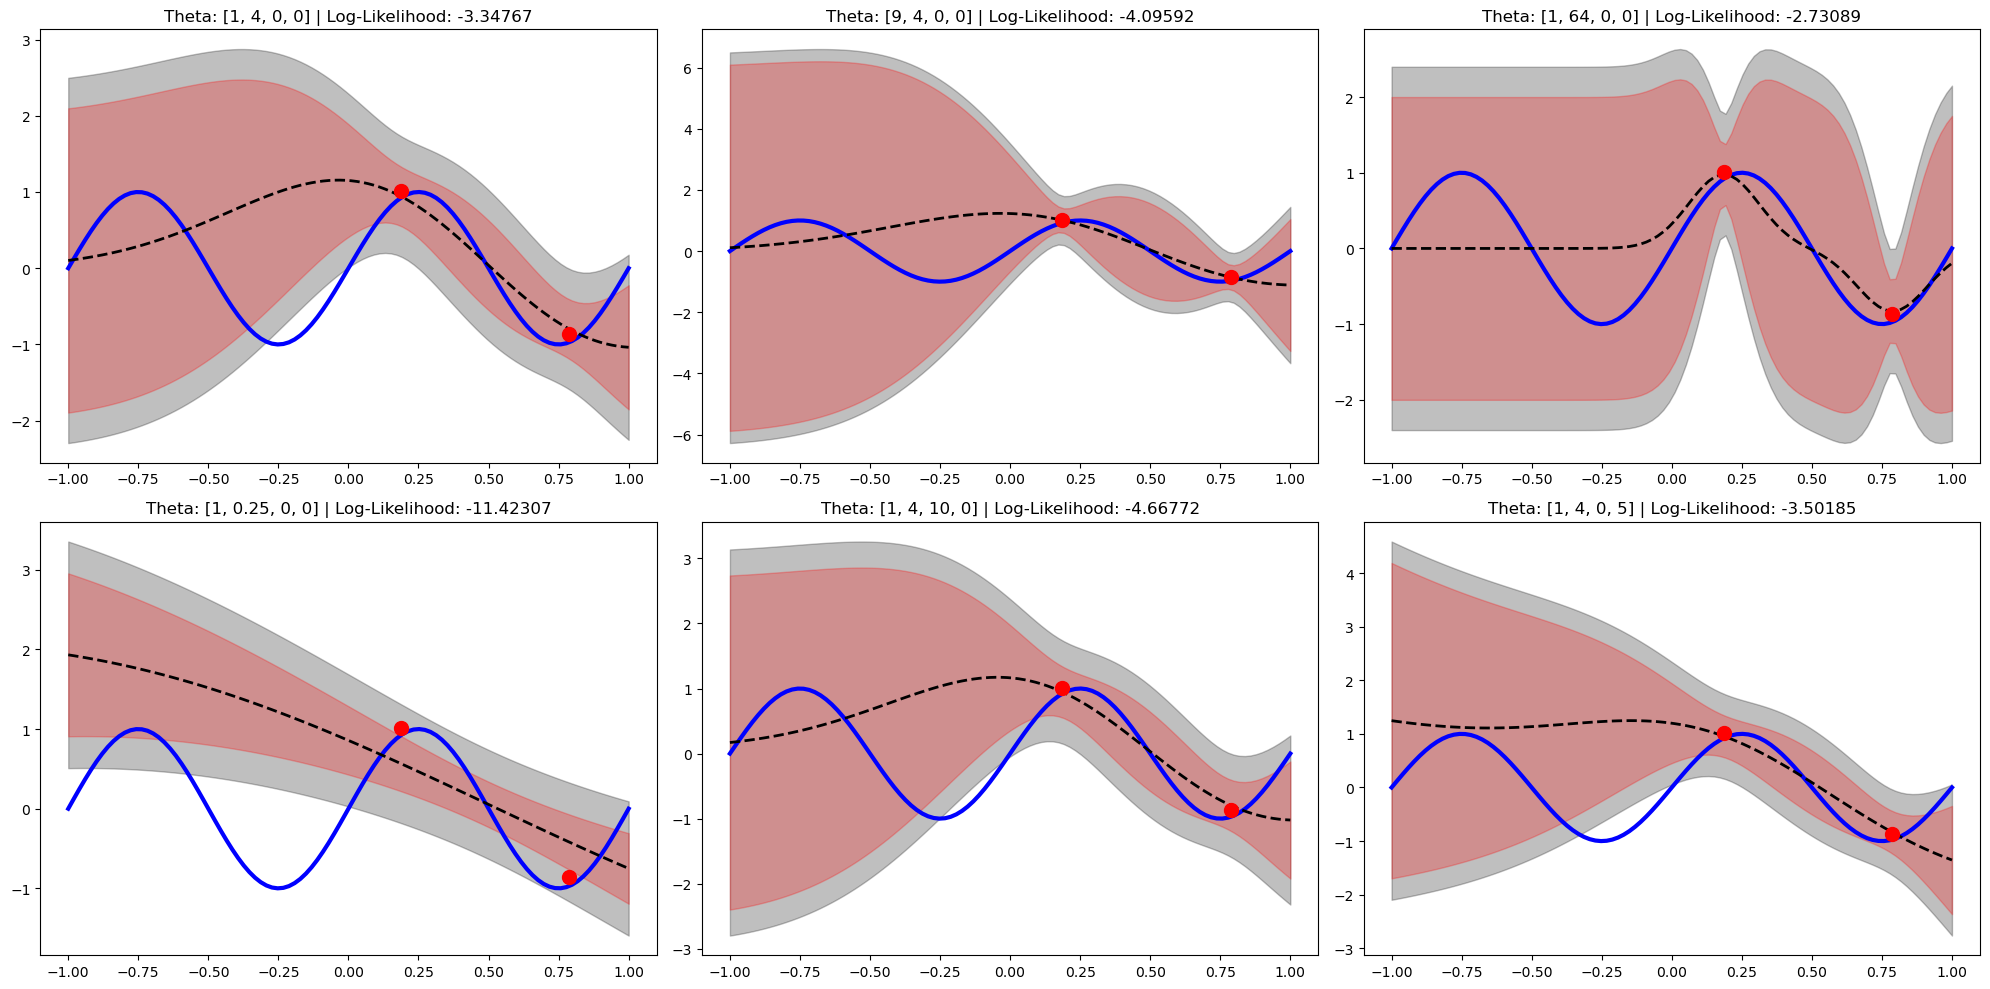

In [49]:
# Retrieve the theta values from Bishop Figure 6.5:
thetas = [[[1, 4, 0, 0], [9, 4, 0, 0], [1, 64, 0, 0]],
          [[1, 0.25, 0, 0], [1, 4, 10, 0], [1, 4, 0, 5]]]

# Step 1: Define all our training and test data and variables

# How many train and test datapoints we want (2 and 100 respectively)
N_train = 2
N_test = 100

# Variables given to us in the beginning
sigma = 0.2
beta  = 1.0 / pow(sigma, 2)

# Generate two random training puts (between -1 and 1, uniform)
x_train = np.random.uniform(-1, 1, N_train)

# Generate t training points
t_train = generate_t(x_train, sigma)

# Generate y training points
y_train = true_mean_function(x_train)

# Generate test data (reuse from given code in beginning)
x_test = np.linspace(-1, 1, N_test) 
y_test = true_mean_function(x_test)

# Step 2: Create a loop that plots for all thetas

# Initialize the figure for the plotting
fig = plt.figure()

# Which subplot are we now looking at (position)
subplot_pos = 1

# Loop over all the thetas
for row in range(2):
    for column in range(3):
        # Take the current theta
        theta = thetas[row][column]
        
        # Retrieve the mean and std of the test data
        test_mean, test_std, C = gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C=None)
        
        # Retrieve the log_likelihood
        lp = gp_log_likelihood(x_train, t_train, theta, beta, C=C, invC=None)[0]
        
        # Select the current subplot position
        plt.subplot(2, 3, subplot_pos)
        
        # Plot the function using gp_plot
        gp_plot(x_test, y_test, test_mean, test_std, x_train, t_train, theta, beta)
        
        # Add 1 to subplot position
        subplot_pos += 1
        
        # Title layout
        plt.title(f"Theta: {theta} | Log-Likelihood: {lp:.5f}")
        
plt.tight_layout()
plt.show()

#### 2.4 More plotting (5 points)
Repeat the 6 plots above, but this time conditioned a new set of 10 training points. (5 points)

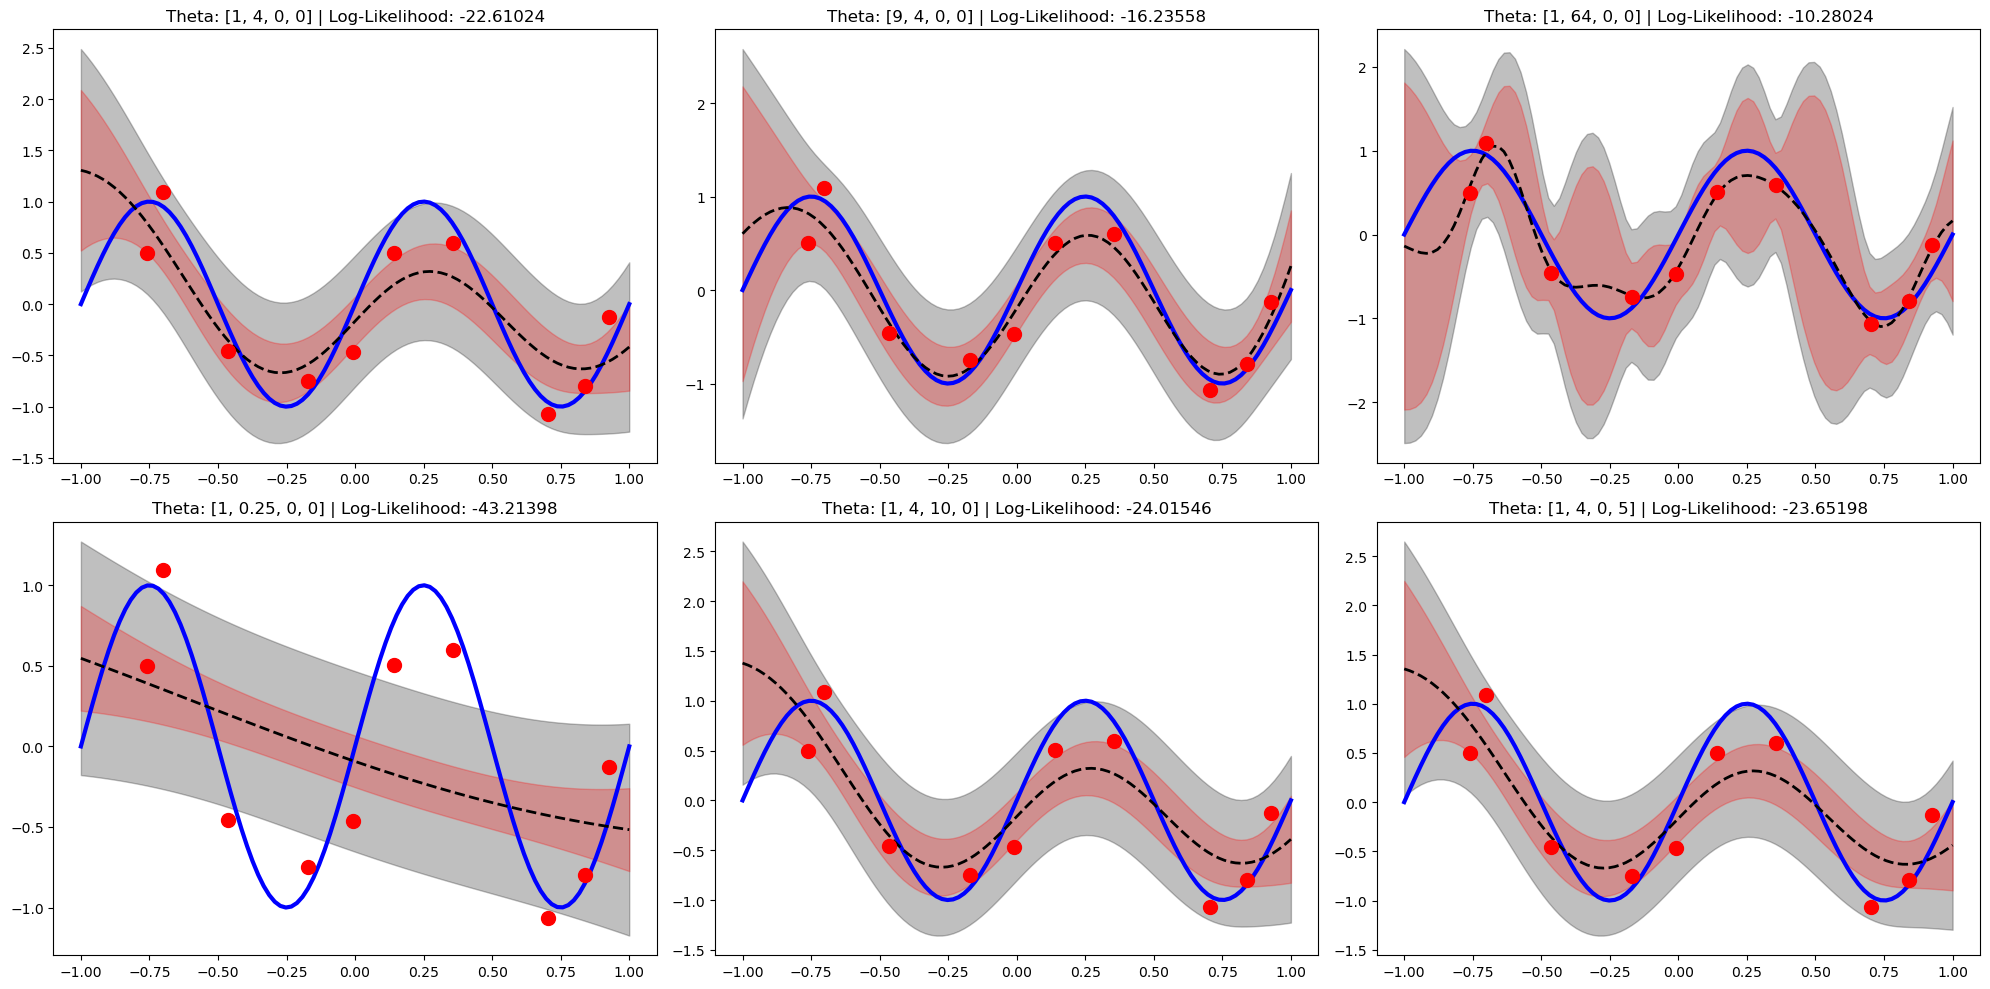

In [50]:
# We are doing the exact same thing as above, but just with 10 training points instead of 2

# Retrieve the theta values from Bishop Figure 6.5:
thetas = [[[1, 4, 0, 0], [9, 4, 0, 0], [1, 64, 0, 0]],
          [[1, 0.25, 0, 0], [1, 4, 10, 0], [1, 4, 0, 5]]]

# Step 1: Define all our training and test data and variables

# How many train and test datapoints we want (2 and 100 respectively)
N_train = 10
N_test = 100

# Variables given to us in the beginning
sigma = 0.2
beta  = 1.0 / pow(sigma, 2)

# Generate two random training puts (between -1 and 1, uniform)
x_train = np.random.uniform(-1, 1, N_train)

# Generate t training points
t_train = generate_t(x_train, sigma)

# Generate y training points
y_train = true_mean_function(x_train)

# Generate test data (reuse from given code in beginning)
x_test = np.linspace(-1, 1, N_test) 
y_test = true_mean_function(x_test)

# Step 2: Create a loop that plots for all thetas

# Initialize the figure for the plotting
fig = plt.figure()

# Which subplot are we now looking at (position)
subplot_pos = 1

# Loop over all the thetas
for row in range(2):
    for column in range(3):
        # Take the current theta
        theta = thetas[row][column]
        
        # Retrieve the mean and std of the test data
        test_mean, test_std, C = gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C=None)
        
        # Retrieve the log_likelihood
        lp = gp_log_likelihood(x_train, t_train, theta, beta, C=C, invC=None)[0]
        
        # Select the current subplot position
        axs = plt.subplot(2, 3, subplot_pos)
        
        # Plot the function using gp_plot
        gp_plot(x_test, y_test, test_mean, test_std, x_train, t_train, theta, beta)
        
        # Add 1 to subplot position
        subplot_pos += 1
        
        plt.title(f"Theta: {theta} | Log-Likelihood: {lp:.5f}")
        
plt.tight_layout()
plt.show()

## Part 2: Support Vector Machines (45 points)
As seen in Part 1: Gaussian Processes, one of the significant limitations of many such algorithms is that the kernel function $k(\bx_n , \bx_m)$ must be evaluated for all possible pairs $\bx_n$ and $\bx_m$ of training points, which can be computationally infeasible during training and can lead to excessive computation times when making predictions for new data points.
In Part 2: Support Vector Machines, we shall look at kernel-based algorithms that have sparse solutions, so that predictions for new inputs depend only on the kernel function evaluated at a subset of the training data points. We are using the same notation as in Bishop chapter 7.

### 2.1 Generating a linearly separable dataset (15 points)
a) (5 points) First of all, we are going to create our own 2D toy dataset $X$. The dataset will consists of two i.i.d. subsets $X_1$ and $X_2$, each of the subsets will be sampled from a multivariate Gaussian distribution,

\begin{align}
X_1 \sim &\mathcal{N}(\mu_1, \Sigma_1)\\
&\text{ and }\\
X_2 \sim &\mathcal{N}(\mu_2, \Sigma_2).
\end{align}

In the following, $X_1$ will have $N_1=20$ samples and a mean $\mu_1=(1,1)$. $X_2$ will have $N_2=30$ samples and a mean $\mu_2=(3,3)$.

Plot the two subsets in one figure, choose two colors to indicate which sample belongs to which subset. In addition you should choose, $\Sigma_1$ and $\Sigma_2$ in a way that the two subsets become linearly separable.

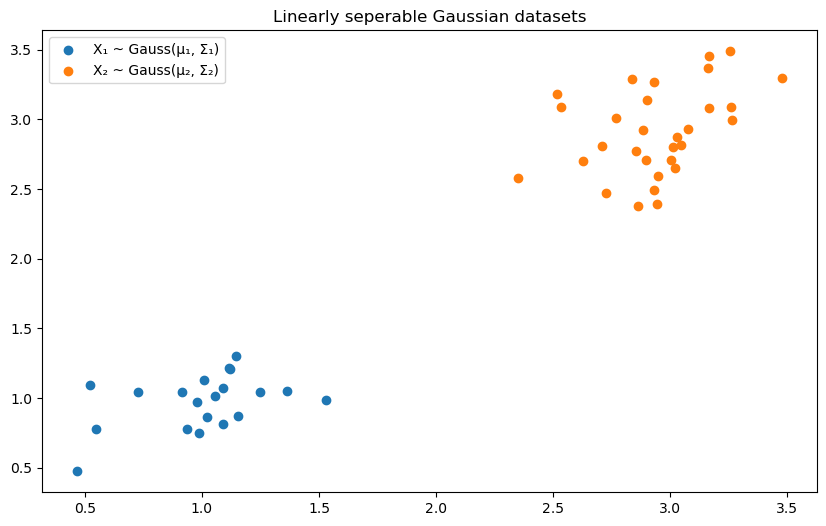

In [51]:
# Function that can plot (because we do it 3 times this assignment, creating a function is cleaner):
def plot_SVM(X1, X2, support_vectors=None, decision_boundary=None):
    #  Figure layout
    fig = plt.figure(figsize=(10,6))
    
    # Plot the points using the Gaussian drawn data
    plt.scatter(X1[:,0], X1[:,1], label='X\u2081 ~ Gauss(\u03BC\u2081, \u03A3\u2081)')
    plt.scatter(X2[:,0], X2[:,1], label='X\u2082 ~ Gauss(\u03BC\u2082, \u03A3\u2082)')
    
    # If we want to plot the support vectors (q2.3)
    if support_vectors is not None:
        plt.scatter(support_vectors[:,0], support_vectors[:,1], marker='1', s=300, label=f'Support Vector')
    
    # If we want to plot the decision boundary (q2.4)
    if decision_boundary is not None:
        plt.plot(decision_boundary[0], decision_boundary[1], color='black', label='Decision Boundary')
    
    # Final layout options
    plt.legend(loc=2)
    plt.title("Linearly seperable Gaussian datasets")

    plt.show()
    
    return

# Initialize the means as given
mu_1 = [1, 1]
mu_2 = [3, 3]

# Choose two covariance that allows us to linearly seperate the data
cov_1 = [[0.06, 0], [0, 0.06]]
cov_2 = [[0.08, 0.03], [0.03, 0.08]]

# Draw the data
X1 = random.multivariate_normal(mu_1, cov_1, 20)
X2 = random.multivariate_normal(mu_2, cov_2, 30)

# Plot the data
plot_SVM(X1, X2)

b) (10 points) In the next step we will combine the two datasets X_1, X_2 and generate a vector `t` containing the labels. Write a function `create_X_and_t(X1, X2)` it should return the combined data set X and the corresponding target vector t.

In [52]:
def create_X_and_t(X1, X2):
    # Amount of datapoints in X1 and X2
    N_X1 = len(X1)
    N_X2 = len(X2)
    
    # Combine X1 and X2 into X
    X = np.vstack((X1, X2))
    
    # Label arrays
    label_1 = np.ones(N_X1)
    label_2 = -1 * np.ones(N_X2)
    
    # Combine the label arrays into t
    t = np.hstack((label_1, label_2))
    
    return X, t 

In [53]:
### Test your function
dim = 2
N1_test = 3
N2_test = 4
X1_test = np.arange(6).reshape((N1_test, dim))
X2_test = np.arange(8).reshape((N2_test, dim))
X_test, t_test = create_X_and_t(X1_test, X2_test)


assert X_test.shape == (N1_test + N2_test, dim), "the shape of X is incorrect"
assert t_test.shape == (N1_test + N2_test,), "the shape of t is incorrect"


### 2.2 Finding the support vectors (15 points)
Finally we going to use a SVM to obtain the decision boundary for which the margin is maximized. We have to solve the optimization problem

\begin{align}
\arg \min_{\bw, b} \frac{1}{2} \lVert \bw \rVert^2,
\end{align}

subject to the constraints

\begin{align}
t_n(\bw^T \phi(\bx_n) + b) \geq 1, n = 1,...,N.
\end{align}

In order to solve this constrained optimization problem, we introduce Lagrange multipliers $a_n \geq 0$. We obtain the dual
representation of the maximum margin problem in which we maximize

\begin{align}
\sum_{n=1}^N a_n - \frac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m t_n t_m k(\bx_n, \bx_m),
\end{align}

with respect to a subject to the constraints

\begin{align}
a_n &\geq 0, n=1,...,N,\\
\sum_{n=1}^N a_n t_n &= 0.
\end{align}

This takes the form of a quadratic programming problem in which we optimize a quadratic function of $\mathbf{a}$, subject to a set of inequality constraints.



a) (5 points) In this example we will use a linear kernel $k(\bx, \bx') = \bx^T\bx'$. Write a function `computeK(X)` that computes the kernel matrix $K$ for the 2D dataset $X$.

In [54]:
def computeK(X):
    # X is of shape NxM
    # K is of shape NxN

    # This means K is the dot product of X with its transpose
    return np.dot(X, X.T)

In [55]:
dim = 2
N_test = 3
X_test = np.arange(2, 8).reshape((N_test, dim))
K_test = computeK(X_test)


assert K_test.shape == (N_test, N_test)


Next, we will rewrite the dual representation so that we can make use of computationally efficient vector-matrix multiplication. The objective becomes

\begin{align}
\min_{\ba} \frac{1}{2} \ba^T K' \ba - 1^T\ba,
\end{align}

subject to the constraints

\begin{align}
a_n &\geq 0, n=1,...,N,\\
\bt^T\ba &= 0.
\end{align}

Where
\begin{align}
K'_{nm} = t_n t_m k(\bx_n, \bx_m),
\end{align}
and in the special case of a linear kernel function,
\begin{align}
K'_{nm} = t_n t_m k(\bx_n, \bx_m) = k(t_n \bx_n, t_m \bx_m).
\end{align}

To solve the quadratic programming problem we will use a python module called cvxopt. You first have to install the module in your virtual environment (you have to activate it first), using the following command:

`conda install -c anaconda cvxopt`

After the installation you probably have to restart Jupyter.

The quadratic programming solver can be called as

`cvxopt.solvers.qp(P, q[, G, h[, A, b[, solver[, initvals]]]])`

This solves the following problem,

\begin{align}
\min_{\bx} \frac{1}{2} \bx^T P \bx + q^T\bx,
\end{align}

subject to the constraints,

\begin{align}
G\bx &\leq h,\\
A\bx &= b.
\end{align}

All we need to do is to map our formulation to the cvxopt interface.

b) (10 points) Write a function `compute_multipliers(X, t)` that solves the quadratic programming problem using the cvxopt module and returns the lagrangian multiplier for every sample in the dataset. 

In [56]:
import cvxopt

def compute_multipliers(X, t):
    # Give the function all the correct matrices
    
    # Get the length of our dataset and target vector for dimensions
    len_X = len(X)
    len_t = len(t)

    # Convert t to array for A matrix calculation and kernel
    t = np.array([t])
    
    # b equals 0 for us, so b is a matrix with 1 value 0
    b = cvxopt.matrix(np.zeros(1))
    
    # q for us is a vector of dimension 2 with values -1 
    q = cvxopt.matrix(-np.ones(len_X))
    
    # A corresponds to the transpose of our target vector
    A = cvxopt.matrix(t)
    
    # We want to create a matrix to use to compute the K_matrix
    
    # Initialize an empty matrix
    K_use_matrix = np.zeros((len_t, X.shape[1]))
    
    for i in range(len_t):
        for j in range(X.shape[1]):
            K_use_matrix[i][j] = t[0][i] * X[i][j]
            
    # K is now the kernel K' given by our K_use_matrix
    K = computeK(K_use_matrix)
    
    # h equals 0 (similar to b), but as a matrix of dim 2 (since we have 2D)
    h = cvxopt.matrix(np.zeros(len_X))

    # For G we flip the inequality sign, so it will be -G
    G = cvxopt.matrix(-np.identity(len_X))
    
    # Code given by assignment from here
    P = cvxopt.matrix(K)
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    a = np.array(sol['x'])
    
    return a

In [57]:
### Test your function
dim = 2
N_test = 3
X_test = np.arange(2, 8).reshape((N_test, dim))
t_test = np.array([-1., 1., 1.])
a_test = compute_multipliers(X_test, t_test)


assert a_test.shape == (N_test, 1)


     pcost       dcost       gap    pres   dres
 0: -7.2895e-01 -1.3626e+00  6e+00  2e+00  2e+00
 1: -3.0230e-01 -6.8816e-01  8e-01  1e-01  1e-01
 2: -2.3865e-01 -3.3686e-01  1e-01  8e-17  3e-15
 3: -2.4973e-01 -2.5198e-01  2e-03  9e-19  2e-15
 4: -2.5000e-01 -2.5002e-01  2e-05  6e-17  4e-16
 5: -2.5000e-01 -2.5000e-01  2e-07  8e-17  2e-15
Optimal solution found.


### 2.3 Plot support vectors (5 points)
Now that we have obtained the lagrangian multipliers $\ba$, we use them to find our support vectors. Repeat the plot from 2.1, this time use a third color to indicate which samples are the support vectors.

     pcost       dcost       gap    pres   dres
 0: -2.5831e+00 -4.4815e+00  1e+02  1e+01  2e+00
 1: -4.1933e-01 -1.7358e+00  9e+00  7e-01  1e-01
 2: -1.7622e-01 -1.1419e+00  1e+00  4e-16  2e-15
 3: -4.5400e-01 -6.7400e-01  2e-01  1e-16  1e-15
 4: -6.1778e-01 -6.6145e-01  4e-02  1e-16  1e-15
 5: -6.5043e-01 -6.5230e-01  2e-03  1e-16  2e-15
 6: -6.5151e-01 -6.5153e-01  2e-05  4e-16  2e-15
 7: -6.5152e-01 -6.5152e-01  2e-07  6e-17  2e-15
Optimal solution found.


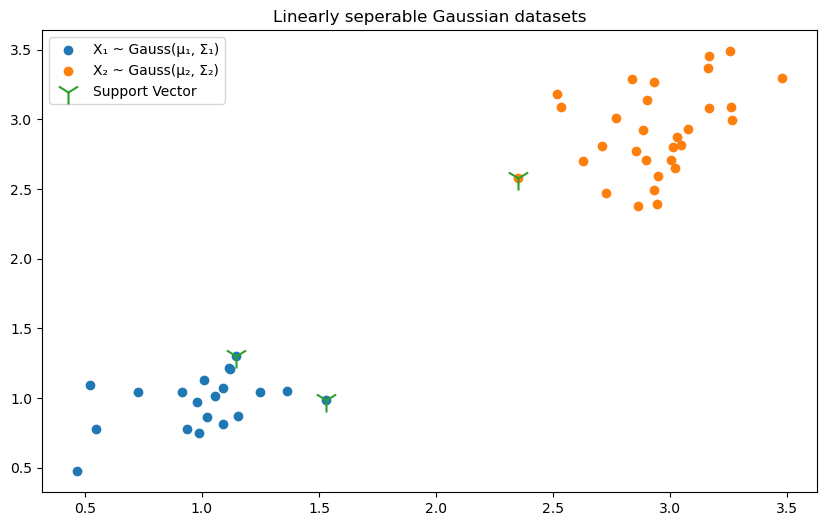

In [58]:
# Function to retrieve indices of support vectors and the actual vectors
def retrieve_SV(lagrange_multipliers, SV_treshold=1e-4):
    # Initialize indices list
    SV_indices = []

    # Retrieve the indices of the Support vectors
    for a in range(len(all_a_values)):
        if all_a_values[a] > SV_treshold:
            SV_indices += [a]

    # Retrieve the actual Support vectors using the indices
    SV_data = []

    for index in SV_indices:
        SV_data += [X[index]]

    # Change back to array
    support_vectors = np.array(SV_data)
    
    return support_vectors, SV_indices


# Create data and target matrices
X, t = create_X_and_t(X1, X2)

# Retrieve the Lagrangian multipliers
all_a_values = compute_multipliers(X, t)
    
# Get the support vectors
support_vectors = retrieve_SV(all_a_values)[0]

# Plot the data and support vectors
plot_SVM(X1, X2, support_vectors)

### 2.4 Plot the decision boundary (10 Points)
The decision boundary is fully specified by a (usually very small) subset of training samples, the support vectors. Make use of

\begin{align}
\bw &= \sum_{n=1}^N a_n t_n \mathbf{\phi}(\bx_n)\\
b &= \frac{1}{N_S}\sum_{n \in S} (t_n - \sum_{m \in S} a_m t_m k(\bx_n, \bx_m)),
\end{align}

where $S$ denotes the set of indices of the support vectors, to calculate the slope and intercept of the decision boundary. Generate a last plot that contains the two subsets, support vectors and decision boundary.

     pcost       dcost       gap    pres   dres
 0: -2.5831e+00 -4.4815e+00  1e+02  1e+01  2e+00
 1: -4.1933e-01 -1.7358e+00  9e+00  7e-01  1e-01
 2: -1.7622e-01 -1.1419e+00  1e+00  4e-16  2e-15
 3: -4.5400e-01 -6.7400e-01  2e-01  1e-16  1e-15
 4: -6.1778e-01 -6.6145e-01  4e-02  1e-16  1e-15
 5: -6.5043e-01 -6.5230e-01  2e-03  1e-16  2e-15
 6: -6.5151e-01 -6.5153e-01  2e-05  4e-16  2e-15
 7: -6.5152e-01 -6.5152e-01  2e-07  6e-17  2e-15
Optimal solution found.


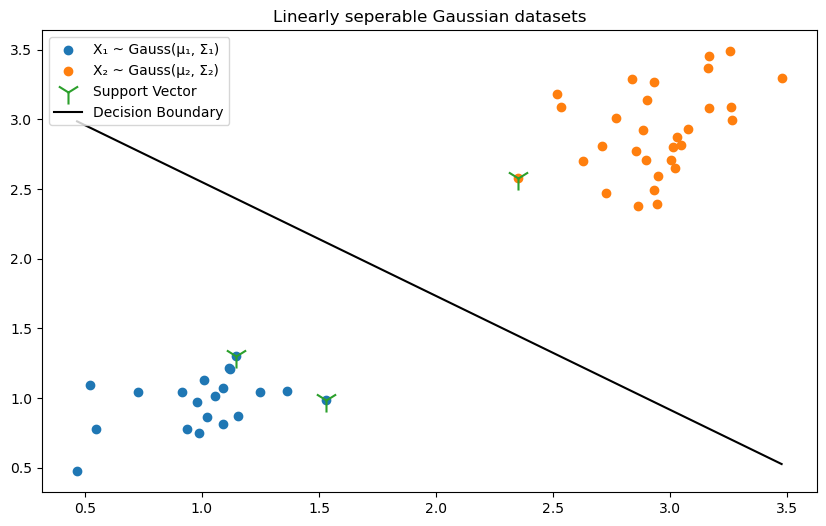

In [59]:
# Function that calculates w
def calculate_w(a, t, X):
    # Initialize the w array
    w = [0, 0]

    # For all indices
    for i in range(len(a)):
        # Perform the multiplication as given by the formula
        w_part = a[i] * t[i] * X[i]
        
        # Perform the sum as given by the formula
        w[0] += w_part[0]
        w[1] += w_part[1]
        
    return w


# Function that calculates b
def calculate_b(t_n, X_n, w):
    
    # Calculate b according to given formula
    b = (1 / len(t_n)) * np.sum((t_n - np.dot(X_n, w)))
    
    return b


# Function that calculates the decision boundary
def decision_boundary(w, b, x1):
    # Background: Points on the line are given by: w.T*x + b = 0
    # Rewrite to: w[0] * x1 + w[1] * x2 + b = 0
    # Meaning: x2 = (-w[0]*x1 - b) / w[1]
    
    # Initialize list to store x2 values
    x2 = []
    
    # For every generated point in the x1 array, calculate x2
    for point in x1:
        x2 += [(-w[0] * point - b) / w[1]]
    
    return x2


# Function that retrieves the boundaries from which we plot the decision boundary between
def get_boundaries(X):
    X_sorted = sort(X[:,0])
    
    return X_sorted[0], X_sorted[-1]


# Create data and target matrices
X, t = create_X_and_t(X1, X2);

# Retrieve the Lagrangian multipliers
a = compute_multipliers(X, t)
    
# Get the support vectors and their indices
a_n, indices = retrieve_SV(a)

# Get the correct target values
t_n = [t[index] for index in indices]

# Get the correct data values
X_n = np.array([X[index] for index in indices])

# Calculate your w and b
w = calculate_w(a, t, X)
b = calculate_b(t_n, X_n, w)

# Generate x-axis data (only need 2 points to plot a line)
left_x, right_x = get_boundaries(X)
x1 = np.linspace(left_x, right_x, 2)

# Calculate the decision boundary
x2 = decision_boundary(w, b, x1)

# Store both in array so we can plot easily using function
decision_boundary = [x1, x2]

# Plotting data, support vectors and decision boundary
plot_SVM(X1, X2, support_vectors, decision_boundary)